<a href="https://colab.research.google.com/github/kallooa/fin-ml/blob/master/Copy_of_Q_Learning_Trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/sp500_closefull.csv

--2021-01-04 16:14:04--  https://lazyprogrammer.me/course_files/sp500_closefull.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 172.67.213.166, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18464866 (18M) [text/csv]
Saving to: ‘sp500_closefull.csv’

sp500_closefull.csv 100%[===================>]  17.61M  97.1MB/s    in 0.2s    

2021-01-04 16:14:04 (97.1 MB/s) - ‘sp500_closefull.csv’ saved [18464866/18464866]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas_datareader.data as web


In [3]:
df0 = pd.read_csv('sp500_closefull.csv', index_col=0, parse_dates=True)
df0.dropna(axis=0, how='all', inplace=True)
df0.dropna(axis=1, how='any', inplace=True)

In [5]:
df_returns = pd.DataFrame()
for name in df0.columns:
  df_returns[name] = np.log(df0[name]).diff()

In [7]:
# split into train and test
Ntest = 1000
train_data = df_returns.iloc[:-Ntest]
test_data = df_returns.iloc[-Ntest:]

In [8]:
feats = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'NFLX']

In [9]:
class Env:
  def __init__(self, df):
    self.df = df
    self.n = len(df)
    self.current_idx = 0
    self.action_space = [0, 1, 2] # BUY, SELL, HOLD
    self.invested = 0

    self.states = self.df[feats].to_numpy()
    self.rewards = self.df['SPY'].to_numpy()

  def reset(self):
    self.current_idx = 0
    return self.states[self.current_idx]

  def step(self, action):
    # need to return (next_state, reward, done)

    self.current_idx += 1
    if self.current_idx >= self.n:
      raise Exception("Episode already done")

    if action == 0: # BUY
      if self.rewards[self.current_idx] >= 0:
        reward = 1 #dollar profit
      else:
        reward = -1 #dollar loss
    elif action == 1: # Sell
      if self.rewards[self.current_idx] >= 0:
        reward = -1 #dollar loss
      else:
        reward = 1 #dollar profit
    else:
      reward = 0
    
    # state transition
    next_state = self.states[self.current_idx]

    done = (self.current_idx == self.n - 1)
    return next_state, reward, done

In [10]:
class StateMapper:
  def __init__(self, env, n_bins=6, n_samples=10000):
    # first, collect sample states from the environment
    states = []
    done = False
    s = env.reset()
    self.D = len(s) # number of elements we need to bin
    states.append(s)
    for _ in range(n_samples):
      a = np.random.choice(env.action_space)
      s2, _, done = env.step(a)
      states.append(s2)
      if done:
        s = env.reset()
        states.append(s)

    # convert to numpy array for easy indexing
    states = np.array(states)

    # create the bins for each dimension
    self.bins = []
    for d in range(self.D):
      column = np.sort(states[:,d])

      # find the boundaries for each bin
      current_bin = []
      for k in range(n_bins):
        boundary = column[int(n_samples / n_bins * (k + 0.5))]
        current_bin.append(boundary)

      self.bins.append(current_bin)


  def transform(self, state):
    x = np.zeros(self.D)
    for d in range(self.D):
      x[d] = int(np.digitize(state[d], self.bins[d]))
    return tuple(x)


  def all_possible_states(self):
    list_of_bins = []
    for d in range(self.D):
      list_of_bins.append(list(range(len(self.bins[d]) + 1)))
    # print(list_of_bins)
    return itertools.product(*list_of_bins)

In [11]:
class Agent:
  def __init__(self, action_size, state_mapper):
    self.action_size = action_size
    self.gamma = 8e-1  # discount rate
    self.epsilon = 10e-2
    self.learning_rate = 10e-2
    self.state_mapper = state_mapper

    # initialize Q-table randomly
    self.Q = {}
    for s in self.state_mapper.all_possible_states():
      s = tuple(s)
      for a in range(self.action_size):
        self.Q[(s,a)] = np.random.randn()

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)

    s = self.state_mapper.transform(state)
    act_values = [self.Q[(s,a)] for a in range(self.action_size)]
    return np.argmax(act_values)  # returns action

  def train(self, state, action, reward, next_state, done):
    s = self.state_mapper.transform(state)
    s2 = self.state_mapper.transform(next_state)

    if done:
      target = reward
    else:
      act_values = [self.Q[(s2,a)] for a in range(self.action_size)]
      target = reward + self.gamma * np.amax(act_values)

    # Run one training step
    self.Q[(s,action)] += self.learning_rate * (target - self.Q[(s,action)])

In [12]:
def play_one_episode(agent, env, is_train):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    total_reward += reward
    if is_train:
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return total_reward

In [13]:
num_episodes = 400

In [14]:
train_env = Env(train_data)
test_env = Env(test_data)

In [15]:
action_size = len(train_env.action_space)
state_mapper = StateMapper(train_env)
agent = Agent(action_size, state_mapper)

In [16]:
train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

In [17]:
for e in range(num_episodes):
  r = play_one_episode(agent, train_env, is_train=True)
  train_rewards[e] = r

  # test on the test set
  tmp_epsilon = agent.epsilon
  agent.epsilon = 0.
  tr = play_one_episode(agent, test_env, is_train=False)
  agent.epsilon = tmp_epsilon
  test_rewards[e] = tr

  print(f"eps: {e + 1}/{num_episodes}, train: {r:.1f}, test: {tr:.1f}")

eps: 1/400, train: -18.0, test: 6.0
eps: 2/400, train: 55.0, test: -1.0
eps: 3/400, train: 90.0, test: -7.0
eps: 4/400, train: 133.0, test: -9.0
eps: 5/400, train: 143.0, test: -9.0
eps: 6/400, train: 185.0, test: -10.0
eps: 7/400, train: 224.0, test: 6.0
eps: 8/400, train: 239.0, test: 0.0
eps: 9/400, train: 211.0, test: 3.0
eps: 10/400, train: 282.0, test: 3.0
eps: 11/400, train: 268.0, test: 0.0
eps: 12/400, train: 316.0, test: 2.0
eps: 13/400, train: 329.0, test: 0.0
eps: 14/400, train: 350.0, test: -1.0
eps: 15/400, train: 357.0, test: 2.0
eps: 16/400, train: 366.0, test: 0.0
eps: 17/400, train: 368.0, test: 4.0
eps: 18/400, train: 377.0, test: 3.0
eps: 19/400, train: 416.0, test: 8.0
eps: 20/400, train: 401.0, test: 8.0
eps: 21/400, train: 407.0, test: 8.0
eps: 22/400, train: 422.0, test: 7.0
eps: 23/400, train: 421.0, test: 8.0
eps: 24/400, train: 413.0, test: 11.0
eps: 25/400, train: 429.0, test: 9.0
eps: 26/400, train: 422.0, test: 9.0
eps: 27/400, train: 421.0, test: 9.0
eps:

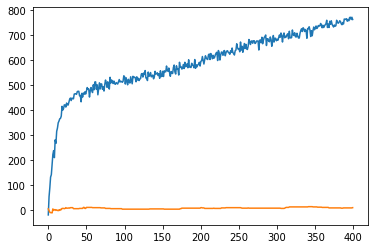

In [18]:
plt.plot(train_rewards)
plt.plot(test_rewards);

In [55]:
spy2019 = web.DataReader(feats + ['SPY'], 'yahoo', '2020-01-01', '2020-12-31')['Close']

for name in spy2019.columns:
  spy2019[name] = np.log(spy2019[name]).diff()

test_env2 = Env(spy2019)

In [56]:
num_episodes = 10

test_rewards = np.empty(num_episodes)

In [57]:

for e in range(num_episodes):

  # test on the test set
  tmp_epsilon = agent.epsilon
  agent.epsilon = 0.
  tr = play_one_episode(agent, test_env2, is_train=False)
  agent.epsilon = tmp_epsilon
  test_rewards[e] = tr

  print(f"eps: {e + 1}/{num_episodes}, train: {r:.1f}, test: {tr:.1f}")

eps: 1/10, train: 763.0, test: -30.0
eps: 2/10, train: 763.0, test: -30.0
eps: 3/10, train: 763.0, test: -30.0
eps: 4/10, train: 763.0, test: -30.0
eps: 5/10, train: 763.0, test: -30.0
eps: 6/10, train: 763.0, test: -30.0
eps: 7/10, train: 763.0, test: -30.0
eps: 8/10, train: 763.0, test: -30.0
eps: 9/10, train: 763.0, test: -30.0
eps: 10/10, train: 763.0, test: -30.0
